In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2021-03-15_18-39_20180601_20191231_base_with_vol_filter.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.002506265664160401

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.333333
ES       0.333333
YM       0.333333
total    1.000000
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    29746.4
NQ    21795.4
YM    27915.8
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

79457.6

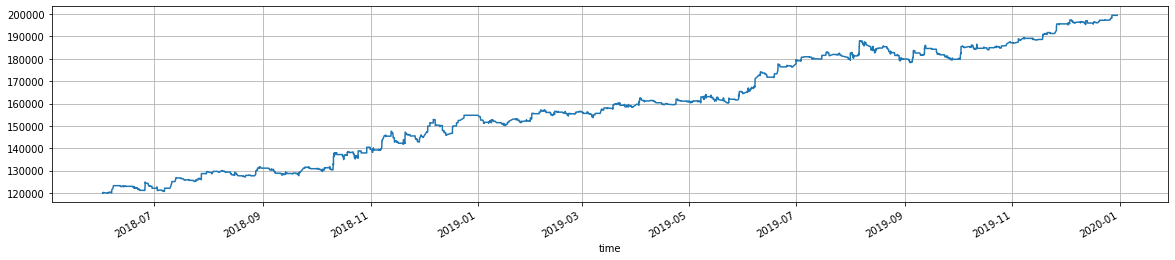

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     216
 NQ    1726
 YM     452
 Name: action, dtype: int64,
 2394)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.524272
 NQ    4.189320
 YM    1.097087
 Name: action, dtype: float64,
 5.810679611650485)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     453.6
NQ    3624.6
YM     949.2
Name: commission, dtype: float64

In [16]:
df.commission.sum()

5027.4000000000015

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.40,25.26,425.58,-238.81,1.78,26.95,863.0
YM,0.44,123.52,759.44,-372.19,2.04,125.73,226.0
ES,0.50,275.43,1081.91,-531.05,2.04,275.43,108.0
total,0.41,66.38,563.67,-285.48,1.97,62.67,1197.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,NQ,YM,total
ES,1.000000,0.185575,0.291211,0.674019
NQ,0.185575,1.000000,0.273365,0.713607
YM,0.291211,0.273365,1.000000,0.732172
total,0.674019,0.713607,0.732172,1.000000


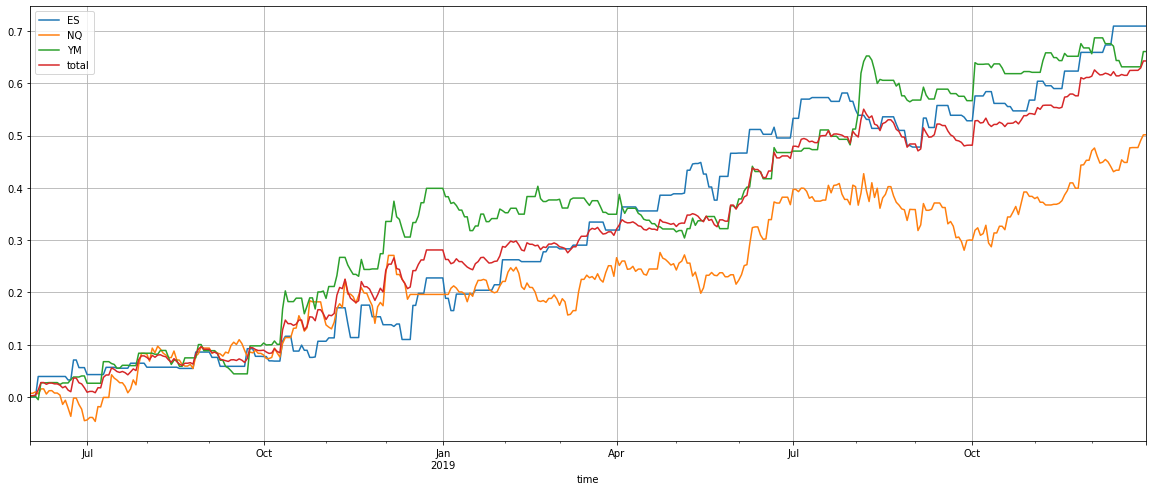

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

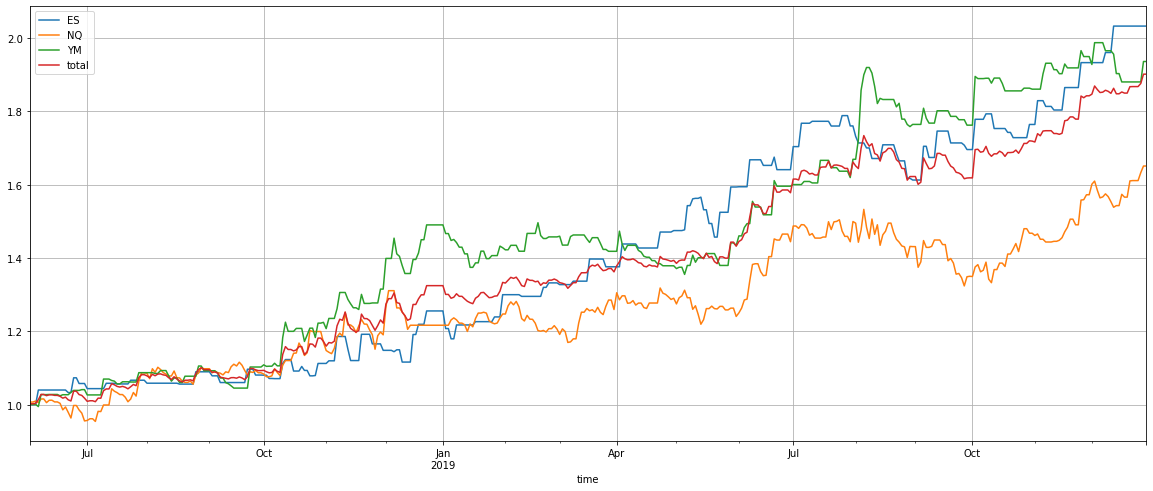

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,YM,total
Annual return,0.543182,0.358905,0.497896,0.481510
Cumulative returns,1.032577,0.651025,0.935970,0.901466
Annual volatility,0.205394,0.231033,0.214577,0.153644
Sharpe ratio,2.214572,1.442562,1.989345,2.635974
Calmar ratio,5.528610,2.633848,5.282691,6.279522
Stability,0.961620,0.903104,0.935916,0.978054
Max drawdown,-0.098249,-0.136266,-0.094251,-0.076679
Omega ratio,2.070107,1.312542,1.683654,1.715546
Sortino ratio,5.007031,2.461318,4.503477,5.824743
Skew,2.108707,0.728186,2.265448,1.664862


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,NQ,YM,total
time,,,,
2018-06-30,5.77,-4.44,4.09,1.77
2018-07-31,0.84,13.73,4.45,6.29
2018-08-31,2.16,1.03,0.49,1.27
2018-09-30,-0.81,-1.00,0.93,-0.23
2018-10-31,2.93,7.65,11.05,7.29
2018-11-30,3.21,1.74,7.40,4.24
2018-12-31,9.36,2.20,13.32,8.37
2019-01-31,3.53,2.52,-4.18,0.67
2019-02-28,2.48,-3.29,2.07,0.43


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       103.0
NQ        65.0
YM        94.0
total     90.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-05 21:19:30,YM,BUY,25629.00,3120.8
2019-10-02 20:46:00,YM,BUY,26070.00,3015.8
2018-10-10 21:49:00,YM,BUY,25798.00,2795.8
2018-12-17 14:36:30,ES,BUY,2592.75,2695.8
2018-12-03 00:01:00,NQ,SELL,7081.25,2610.8
...,...,...,...,...
2018-10-16 14:56:30,ES,BUY,2771.25,-1116.7
2019-08-28 16:42:00,ES,BUY,2877.50,-1141.7
2018-12-11 20:44:00,ES,BUY,2649.25,-1166.7


In [26]:
daily.sort_values('total', ascending=False)

,ES,NQ,YM,total
time,,,,
2019-10-02,0.048645,0.019225,0.075395,0.047755
2018-10-10,0.038645,0.026535,0.069895,0.045025
2018-12-03,0.000000,0.063935,0.063645,0.042527
2019-09-05,0.057083,0.041810,0.025040,0.041311
2018-11-20,0.063958,0.015080,0.032770,0.037269
...,...,...,...,...
2018-12-11,-0.029168,-0.008855,-0.017855,-0.018626
2018-10-22,-0.009792,-0.017315,-0.029460,-0.018856
2019-08-28,-0.028543,-0.020190,-0.008230,-0.018988
